In [1]:
# Load packages and read in data
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.neighbors import KernelDensity


cFP_rates = pd.read_csv("/Users/Corey/git/ThreeStateMelanoma/cFP_rates_VUlines.csv")
dat_DS9 = cFP_rates[cFP_rates['Cell_Line'] == 'PC9-DS9']

df_DS9_expansion_twoState_DivsLow_LeftDIP = pd.read_pickle('PC9-DS9_param-scan_twoState-ER_DivsLow-LeftDIP.pkl')
df_DS9_expansion_twoState_DivsLow_RightDIP = pd.read_pickle('PC9-DS9_param-scan_twoState-ER_DivsLow-RightDIP.pkl')
df_DS9_expansion_twoState_DivsHigh_LeftDIP = pd.read_pickle('PC9-DS9_param-scan_twoState-ER_DivsHigh-LeftDIP.pkl')
df_DS9_expansion_twoState_DivsHigh_RightDIP = pd.read_pickle('PC9-DS9_param-scan_twoState-ER_DivsHigh-RightDIP.pkl')

In [2]:
## Add cell line annotation to data
df_DS9_expansion_twoState_DivsLow_LeftDIP['cell line'] = 'PC9.DS9'
df_DS9_expansion_twoState_DivsLow_RightDIP['cell line'] = 'PC9.DS9'
df_DS9_expansion_twoState_DivsHigh_LeftDIP['cell line'] = 'PC9.DS9'
df_DS9_expansion_twoState_DivsHigh_RightDIP['cell line'] = 'PC9.DS9'

In [3]:
df_DS9_expansion_twoState_DivsLow_LeftDIP.head()

,DIP rate,division rate,death rate,proportions,sim DIPs,KS p-value,AD p-value,cell line
0,"[0.0012, -0.0007]","[0.015, 0.01]","[0.0138, 0.0107]","[0.95, 0.050000000000000044]","[0.0018243711731444775, 0.0009693901448588573,...","[0.003765680844836839, 0.013083715897581739, 0...","[0.0011399503382979838, 0.007677558849173094, ...",PC9.DS9
1,"[0.0012, -0.0007]","[0.015, 0.01]","[0.0138, 0.0107]","[0.96, 0.040000000000000036]","[0.001935093368816702, 0.000596666006775358, 0...","[0.07573985345560834, 0.09216424815490226, 0.0...","[0.05454019432548253, 0.033194779679194215, 0....",PC9.DS9
2,"[0.0012, -0.0007]","[0.015, 0.01]","[0.0138, 0.0107]","[0.97, 0.030000000000000027]","[0.0018973991036236653, 0.001151984341776805, ...","[0.14949607027356193, 0.02233284250080246, 0.0...","[0.060672637632002896, 0.0042030345375460906, ...",PC9.DS9
3,"[0.0012, -0.0007]","[0.015, 0.01]","[0.0138, 0.0107]","[0.98, 0.020000000000000018]","[-0.0025967873565194495, -0.001624269184954416...","[0.17448054973767116, 0.09439209389755894, 0.0...","[0.16892489254346704, 0.03835866659383954, 0.0...",PC9.DS9
4,"[0.0012, -0.0007]","[0.015, 0.01]","[0.0138, 0.0107]","[0.99, 0.010000000000000009]","[0.004096472576790942, 0.00025908380321472445,...","[0.020705438068883225, 0.03456449609030803, 0....","[0.020135248282009983, 0.03290840465669234, 0....",PC9.DS9


In [4]:
## Create pandas objects from simulated data parameters (separated by each
## parameter scan ranges (low, lowMed, medHigh, high)
### DivsLow_LeftDIP
DS9_dipdf_DivsLow_LeftDIP = pd.DataFrame(df_DS9_expansion_twoState_DivsLow_LeftDIP['DIP rate'].values.tolist(), columns=['DIP1','DIP2'])
DS9_divdf_DivsLow_LeftDIP = pd.DataFrame(df_DS9_expansion_twoState_DivsLow_LeftDIP['division rate'].values.tolist(), columns=['div1','div2'])
DS9_dthdf_DivsLow_LeftDIP = pd.DataFrame(df_DS9_expansion_twoState_DivsLow_LeftDIP['death rate'].values.tolist(), columns=['dth1','dth2'])
DS9_propdf_DivsLow_LeftDIP = pd.DataFrame(df_DS9_expansion_twoState_DivsLow_LeftDIP['proportions'].values.tolist(), columns=['prop1','prop2'])
DS9_cellline_DivsLow_LeftDIP = df_DS9_expansion_twoState_DivsLow_LeftDIP['cell line']

DS9_KSval_DivsLow_LeftDIP = []
DS9_ADval_DivsLow_LeftDIP = []
for index, row in df_DS9_expansion_twoState_DivsLow_LeftDIP.iterrows():
    DS9_KSval_DivsLow_LeftDIP.append(np.mean(np.array(df_DS9_expansion_twoState_DivsLow_LeftDIP['KS p-value'][index])) - 1*np.std(np.array(df_DS9_expansion_twoState_DivsLow_LeftDIP['KS p-value'][index])))
    DS9_ADval_DivsLow_LeftDIP.append(np.mean(np.array(df_DS9_expansion_twoState_DivsLow_LeftDIP['AD p-value'][index])) - 1*np.std(np.array(df_DS9_expansion_twoState_DivsLow_LeftDIP['AD p-value'][index])))

# DS9_cellline_DivsLow_LeftDIP.reset_index(drop=True)
# DS9_cellline_DivsLow_LeftDIP




In [5]:
def model_comparison(dat, sim, i, param_num):
    
    dat_ls = np.array(dat["DIP_Rate"].values.tolist())
    sim_ls = np.array(sim[i])

    n = len(dat_ls)

    tog = np.append(dat_ls, sim_ls)

    x_d = np.linspace(min(tog), max(tog), 1000)
    # instantiate and fit the KDE model
    kde_e = KernelDensity(bandwidth=(max(tog)-min(tog))/50, kernel='gaussian')
    kde_e.fit(dat_ls[:, None])
    kde_s = KernelDensity(bandwidth=(max(tog)-min(tog))/50, kernel='gaussian')
    kde_s.fit(sim_ls[:, None])

    # score_samples returns the log of the probability density
    logprob_e = kde_e.score_samples(x_d[:, None])
    logprob_s = kde_s.score_samples(x_d[:, None])

    kde_vals_e = np.exp(logprob_e)
    kde_vals_s = np.exp(logprob_s)

    norm_e_list = [np.random.normal(loc = ex, scale = ex*0.1, 
                                    size = 100) for ex in kde_vals_e]

    p=[]
    for i in range(len(kde_vals_s)):
        p.append(sp.stats.ttest_1samp(norm_e_list[i], kde_vals_s[i])[1])

    p_log = np.log10(p)
    sumLL = np.ma.masked_invalid(p_log).sum()
    aic = 2 * param_num - 2 * (sumLL)
    aic_c = aic + (2*param_num * (param_num-1)) / (n-param_num-1)
    return sumLL, aic, aic_c  

In [8]:
# DS9_DivsLow_LeftDIP = pd.concat([DS9_dipdf_DivsLow_LeftDIP.reset_index(drop=True),
#                                 DS9_divdf_DivsLow_LeftDIP.reset_index(drop=True),
#                                 DS9_dthdf_DivsLow_LeftDIP.reset_index(drop=True),
#                                 DS9_propdf_DivsLow_LeftDIP.reset_index(drop=True),
#                                 DS9_cellline_DivsLow_LeftDIP.reset_index(drop=True)],
#                                axis = 1)

# DS9_DivsLow_LeftDIP['KS val'] = DS9_KSval_DivsLow_LeftDIP
# DS9_DivsLow_LeftDIP['AD val'] = DS9_ADval_DivsLow_LeftDIP
# DS9_DivsLow_LeftDIP['LLC'] = DS9_sumLL_DivsLow_LeftDIP
# DS9_DivsLow_LeftDIP['AIC'] = DS9_aic_DivsLow_LeftDIP
# DS9_DivsLow_LeftDIP['AICc'] = DS9_aicc_DivsLow_LeftDIP

# DS9_DivsLow_LeftDIP.head()

NameError: name 'DS9_sumLL_DivsLow_LeftDIP' is not defined

In [6]:
def analyze_model(pkl_file, population, data, num_params):
    ## Read in dataset
    df = pd.read_pickle(pkl_file)
    df['cell line'] = population

    ## Create pandas objects from simulated data parameters
    df_dip = pd.DataFrame(df['DIP rate'].values.tolist(), columns=['DIP1','DIP2'])
    df_div = pd.DataFrame(df['division rate'].values.tolist(), columns=['div1','div2'])
    df_dth = pd.DataFrame(df['death rate'].values.tolist(), columns=['dth1','dth2'])
    df_prop = pd.DataFrame(df['proportions'].values.tolist(), columns=['prop1','prop2'])
    df_cellline = df['cell line']

    sim = np.array(df['sim DIPs'])

    KSval = []
    ADval = []
    sumLL = []
    aic_n = []
    aic_c = []

    for index, row in df.iterrows():
        KSval.append(np.mean(np.array(df['KS p-value'][index])) + 2*np.std(np.array(df['KS p-value'][index])))
        ADval.append(np.mean(np.array(df['AD p-value'][index])) + 2*np.std(np.array(df['AD p-value'][index])))
        sll, aicn, aicc = model_comparison(dat = data, sim = sim, i = index, param_num = num_params)
        sumLL.append(sll)
        aic_n.append(aicn)
        aic_c.append(aicc)

    df_c = pd.concat([df_dip.reset_index(drop=True),
                      df_div.reset_index(drop=True),
                      df_dth.reset_index(drop=True),
                      df_prop.reset_index(drop=True),
                      df_cellline.reset_index(drop=True)],
                     axis = 1)

    df_c['KS val'] = KSval
    df_c['AD val'] = ADval
    df_c['LLC'] = sumLL
    df_c['AIC'] = aic_n
    df_c['AICc'] = aic_c
    
    return(df_c)

In [7]:
# Example Inputs
pkl_file = 'PC9-DS9_param-scan_twoState-ER_DivsLow-LeftDIP.pkl'
population = 'PC9.DS9'
cFP_rates = pd.read_csv("/Users/Corey/git/ThreeStateMelanoma/cFP_rates_VUlines.csv")
dat_DS9 = cFP_rates[cFP_rates['Cell_Line'] == 'PC9-DS9']
data = dat_DS9

In [8]:
DS9_E2S_DivsLow_LeftDIP = analyze_model(pkl_file='PC9-DS9_param-scan_twoState-ER_DivsLow-LeftDIP.pkl',
                                       population = 'PC9.DS9', data = dat_DS9, num_params = 4)
DS9_E2S_DivsLow_RightDIP = analyze_model(pkl_file='PC9-DS9_param-scan_twoState-ER_DivsLow-RightDIP.pkl',
                                       population = 'PC9.DS9', data = dat_DS9, num_params = 4)
DS9_E2S_DivsHigh_LeftDIP = analyze_model(pkl_file='PC9-DS9_param-scan_twoState-ER_DivsHigh-LeftDIP.pkl',
                                       population = 'PC9.DS9', data = dat_DS9, num_params = 4)
DS9_E2S_DivsHigh_RightDIP = analyze_model(pkl_file='PC9-DS9_param-scan_twoState-ER_DivsHigh-RightDIP.pkl',
                                       population = 'PC9.DS9', data = dat_DS9, num_params = 4)

/Users/Corey/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/Users/Corey/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/Users/Corey/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/Users/Corey/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


In [9]:
DS9_E2S_DivsLow_RightDIP.head()

,DIP1,DIP2,div1,div2,dth1,dth2,prop1,prop2,cell line,KS val,AD val,LLC,AIC,AICc
0,0.0012,0.0018,0.015,0.01,0.0138,0.0082,0.95,0.05,PC9.DS9,0.299117,0.122159,-56704.786106,113417.572212,113417.664876
1,0.0012,0.0018,0.015,0.01,0.0138,0.0082,0.96,0.04,PC9.DS9,0.035741,0.010734,-67718.708515,135445.417030,135445.509694
2,0.0012,0.0018,0.015,0.01,0.0138,0.0082,0.97,0.03,PC9.DS9,0.108129,0.049043,-78380.212788,156768.425576,156768.518240
3,0.0012,0.0018,0.015,0.01,0.0138,0.0082,0.98,0.02,PC9.DS9,0.125768,0.100100,-51736.819329,103481.638657,103481.731321
4,0.0012,0.0018,0.015,0.01,0.0138,0.0082,0.99,0.01,PC9.DS9,0.252483,0.102284,-64132.243216,128272.486433,128272.579097


In [14]:
DS9_2S_all = pd.concat([DS9_E2S_DivsLow_LeftDIP, DS9_E2S_DivsLow_RightDIP, 
                        DS9_E2S_DivsHigh_LeftDIP, DS9_E2S_DivsHigh_RightDIP], 
                       ignore_index = True)

In [15]:
DS9_2S_all.head()

,DIP1,DIP2,div1,div2,dth1,dth2,prop1,prop2,cell line,KS val,AD val,LLC,AIC,AICc
0,0.0012,-0.0007,0.015,0.01,0.0138,0.0107,0.95,0.05,PC9.DS9,0.141934,0.032914,-65114.385352,130236.770704,130236.863368
1,0.0012,-0.0007,0.015,0.01,0.0138,0.0107,0.96,0.04,PC9.DS9,0.169010,0.093436,-74981.152204,149970.304408,149970.397072
2,0.0012,-0.0007,0.015,0.01,0.0138,0.0107,0.97,0.03,PC9.DS9,0.117068,0.029592,-74959.038410,149926.076820,149926.169484
3,0.0012,-0.0007,0.015,0.01,0.0138,0.0107,0.98,0.02,PC9.DS9,0.247484,0.119200,-70121.180601,140250.361201,140250.453865
4,0.0012,-0.0007,0.015,0.01,0.0138,0.0107,0.99,0.01,PC9.DS9,0.125596,0.072484,-68447.597143,136903.194286,136903.286950


In [16]:
df_DS9_expansion_oneState = pd.read_pickle('PC9-DS9_param-scan_Expansion.pkl')
df_DS9_expansion_oneState['cell line'] = 'PC9.DS9'

df_DS9_expansion_oneState = df_DS9_expansion_oneState[['cell line', 'division rate', 'death rate', 'DIP rate', 
                                     'sim DIPs', 'KS p-value', 'AD p-value']]

KS_val = []
AD_val = []
for index, row in df_DS9_expansion_oneState.iterrows():
    KS_val.append(np.mean(np.array(df_DS9_expansion_oneState['KS p-value'][index])) - 1*np.std(np.array(df_DS9_expansion_oneState['KS p-value'][index])))
    AD_val.append(np.mean(np.array(df_DS9_expansion_oneState['AD p-value'][index])) - 1*np.std(np.array(df_DS9_expansion_oneState['AD p-value'][index])))

df_DS9_expansion_oneState['KS val'] = KS_val
df_DS9_expansion_oneState['AD val'] = AD_val

# df_DS9_expansion_oneState = df_DS9_expansion_oneState[['cell line', 'division rate', 'death rate', 'DIP rate', 'KS val', 'AD val']]

df_DS9_expansion_oneState = df_DS9_expansion_oneState.sort_values(by='AD val', ascending=False)
df_DS9_expansion_oneState.head()

,cell line,division rate,death rate,DIP rate,sim DIPs,KS p-value,AD p-value,KS val,AD val
857,PC9.DS9,0.015,0.0138,0.0012,"[0.001050030492476729, 0.0019320905226265976, ...","[0.4274445358413178, 0.3182828593417164, 0.134...","[0.25, 0.09190897227890968, 0.0586027290554017...",0.882994,0.352436
934,PC9.DS9,0.021,0.0197,0.0013,"[0.0020765401234607754, 0.013063075240473933, ...","[0.4782211583726786, 0.05625655704339627, 0.08...","[0.25, 0.07474387338439813, 0.1654874126588413...",0.999032,0.351744
643,PC9.DS9,0.014,0.0131,0.0009,"[0.0004942178638337067, 0.0013466078025626367,...","[0.4342538522060315, 0.1950724458887061, 0.229...","[0.25, 0.25, 0.25, 0.24279287348490902, 0.0748...",0.756085,0.350526
854,PC9.DS9,0.012,0.0108,0.0012,"[0.0007212618260883187, 0.0024410316327409948,...","[0.23060702183992368, 0.0885780736687668, 0.43...","[0.1857250653016529, 0.09021796877827742, 0.25...",0.921704,0.348433
856,PC9.DS9,0.014,0.0128,0.0012,"[0.0017906969446097468, 0.005734080261770735, ...","[0.19645307042903487, 0.0886084398934555, 0.72...","[0.25, 0.21730658670752143, 0.25, 0.25, 0.25, ...",0.881949,0.346378


In [17]:
topSimResult = np.array(df_DS9_expansion_oneState['sim DIPs'])
sll_1S, aic_n_1S, aic_c_1S = model_comparison(dat=dat_DS9, sim=topSimResult, param_num=2, i=0)

/Users/Corey/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


In [18]:
AIC_c_all = DS9_2S_all['AICc'].values.tolist()
# AIC_c_all.append(aic_c_1S)
# DS9_2S_all['AICp'] = np.exp((np.min(AIC_c_all)-DS9_2S_all['AICc'])/2)

In [19]:
aic_c_1S

77445.75708677873

In [40]:
DS9_2S_all.sort_values(by=['AICc']).head(20)

,DIP1,DIP2,div1,div2,dth1,dth2,prop1,prop2,cell line,KS val,AD val,LLC,AIC,AICc,AICp
5160,0.0012,0.0002,0.015,0.067,0.0138,0.0668,0.95,0.05,PC9.DS9,0.672423,0.310432,-26976.976737,53961.953475,53962.046139,1.0
4430,0.0012,-0.0001,0.015,0.054,0.0138,0.0541,0.95,0.05,PC9.DS9,0.660041,0.284396,-34764.866619,69537.733238,69537.825902,0.0
1427,0.0012,0.0003,0.015,0.035,0.0138,0.0347,0.97,0.03,PC9.DS9,0.313764,0.204767,-34912.875446,69833.750892,69833.843556,0.0
7141,0.0012,0.0027,0.015,0.068,0.0138,0.0653,0.96,0.04,PC9.DS9,0.443223,0.286226,-35320.407280,70648.814560,70648.907224,0.0
791,0.0012,-0.0003,0.015,0.024,0.0138,0.0243,0.96,0.04,PC9.DS9,0.207919,0.113677,-35402.720508,70813.441015,70813.533680,0.0
4616,0.0012,0.0003,0.015,0.057,0.0138,0.0567,0.96,0.04,PC9.DS9,0.491840,0.256569,-35531.614505,71071.229009,71071.321674,0.0
2168,0.0012,0.0022,0.015,0.013,0.0138,0.0108,0.98,0.02,PC9.DS9,0.136095,0.051044,-36670.208241,73348.416482,73348.509146,0.0
1811,0.0012,0.0003,0.015,0.042,0.0138,0.0417,0.96,0.04,PC9.DS9,0.313332,0.159421,-36720.706778,73449.413556,73449.506220,0.0
5741,0.0012,-0.0003,0.015,0.078,0.0138,0.0783,0.96,0.04,PC9.DS9,0.584598,0.318226,-37161.785455,74331.570909,74331.663573,0.0
4566,0.0012,-0.0007,0.015,0.057,0.0138,0.0577,0.96,0.04,PC9.DS9,0.237145,0.118556,-37414.037977,74836.075953,74836.168617,0.0


/Users/Corey/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


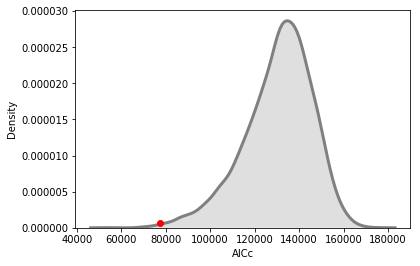

In [41]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.distplot(DS9_2S_all['AICc'], color = "grey", hist = False,
            kde_kws={"shade": True, "lw": 3})
ax.plot([aic_c_1S], [0.0000007], marker = "o", color = "red")
plt.ylabel("Density")
# sns.pointplot(x = aic_c_1S, color="red")
plt.savefig('DS9_twoState_AICc_KDE.pdf', dpi=300, bbox_inches='tight')
# 17/7810 had higher AIC

In [35]:
DS9_2S_all.sort_values(by='AICc').head(20)

,DIP1,DIP2,div1,div2,dth1,dth2,prop1,prop2,cell line,KS val,AD val,LLC,AIC,AICc,aic_new,aic_c_new
5160,0.0012,0.0002,0.015,0.067,0.0138,0.0668,0.95,0.05,PC9.DS9,0.672423,0.310432,-27275.490713,54558.981425,54559.074089,-10.427488,-10.272449
4430,0.0012,-0.0001,0.015,0.054,0.0138,0.0541,0.95,0.05,PC9.DS9,0.660041,0.284396,-34729.044686,69466.089371,69466.182035,-10.910663,-10.755625
7141,0.0012,0.0027,0.015,0.068,0.0138,0.0653,0.96,0.04,PC9.DS9,0.443223,0.286226,-35005.535094,70019.070189,70019.162853,-10.926523,-10.771484
1427,0.0012,0.0003,0.015,0.035,0.0138,0.0347,0.97,0.03,PC9.DS9,0.313764,0.204767,-35434.626645,70877.253289,70877.345953,-10.950890,-10.795851
4616,0.0012,0.0003,0.015,0.057,0.0138,0.0567,0.96,0.04,PC9.DS9,0.491840,0.256569,-35515.558835,71039.117670,71039.210334,-10.955452,-10.800414
791,0.0012,-0.0003,0.015,0.024,0.0138,0.0243,0.96,0.04,PC9.DS9,0.207919,0.113677,-35768.049861,71544.099722,71544.192386,-10.969621,-10.814582
1811,0.0012,0.0003,0.015,0.042,0.0138,0.0417,0.96,0.04,PC9.DS9,0.313332,0.159421,-36742.762599,73493.525197,73493.617862,-11.023393,-10.868354
4566,0.0012,-0.0007,0.015,0.057,0.0138,0.0577,0.96,0.04,PC9.DS9,0.237145,0.118556,-36803.326976,73614.653951,73614.746616,-11.026687,-10.871648
2168,0.0012,0.0022,0.015,0.013,0.0138,0.0108,0.98,0.02,PC9.DS9,0.136095,0.051044,-37211.521300,74431.042600,74431.135264,-11.048747,-10.893709
5741,0.0012,-0.0003,0.015,0.078,0.0138,0.0783,0.96,0.04,PC9.DS9,0.584598,0.318226,-37488.486841,74984.973683,74985.066347,-11.063578,-10.908540


In [75]:
aic_c_1S

77474.61131667947

In [20]:
test = DS9_2S_all

In [27]:
param_num = 5
n=len(dat_DS9["DIP_Rate"])
test['aic_new'] = 2 * param_num - 2 * np.log(-test['LLC'])
test['aic_c_new'] = test['aic_new'] + (2*param_num * (param_num-1)) / (n-param_num-1)

In [33]:
test.sort_values(by='AICc').tail(100)

,DIP1,DIP2,div1,div2,dth1,dth2,prop1,prop2,cell line,KS val,AD val,LLC,AIC,AICc,aic_new,aic_c_new
6247,0.0012,0.0024,0.015,0.052,0.0138,0.0496,0.97,0.03,PC9.DS9,0.055930,0.015170,-79263.242832,158534.485665,158534.578329,-12.561060,-12.406021
561,0.0012,-0.0005,0.015,0.020,0.0138,0.0205,0.96,0.04,PC9.DS9,0.177354,0.125374,-79269.797984,158547.595968,158547.688632,-12.561225,-12.406186
6888,0.0012,0.0020,0.015,0.064,0.0138,0.0620,0.98,0.02,PC9.DS9,0.017895,0.004308,-79277.862733,158563.725467,158563.818131,-12.561428,-12.406390
4159,0.0012,-0.0001,0.015,0.049,0.0138,0.0491,0.99,0.01,PC9.DS9,0.121701,0.049060,-79296.653238,158601.306475,158601.399140,-12.561902,-12.406864
4824,0.0012,0.0000,0.015,0.061,0.0138,0.0610,0.99,0.01,PC9.DS9,0.066386,0.032072,-79312.658037,158633.316073,158633.408737,-12.562306,-12.407267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,0.0012,0.0001,0.015,0.033,0.0138,0.0329,0.99,0.01,PC9.DS9,0.026289,0.006623,-83963.294840,167934.589680,167934.682344,-12.676270,-12.521231
2530,0.0012,0.0018,0.015,0.020,0.0138,0.0182,0.95,0.05,PC9.DS9,0.008778,0.002490,-84606.818003,169221.636007,169221.728671,-12.691540,-12.536502
1222,0.0012,-0.0005,0.015,0.032,0.0138,0.0325,0.97,0.03,PC9.DS9,0.015172,0.008122,-84931.036623,169870.073245,169870.165909,-12.699190,-12.544151
531,0.0012,0.0000,0.015,0.019,0.0138,0.0190,0.96,0.04,PC9.DS9,0.121670,0.044799,-85798.944690,171605.889381,171605.982045,-12.719524,-12.564485


In [31]:
param_num = 2
n=len(dat_DS9["DIP_Rate"])
aic_new_1s = 2 * param_num - 2 * np.log(-sll_1S)
aicc_new_1s = aic_new_1s + (2*param_num * (param_num-1)) / (n-param_num-1)
aicc_new_1s

-17.112942395276768

In [38]:
test['aic_c_new']

0      -12.012763
1      -12.294945
2      -12.294355
3      -12.160922
4      -12.112609
          ...    
7805   -12.064164
7806   -12.184467
7807   -11.966305
7808   -11.968971
7809   -12.325696
Name: aic_c_new, Length: 7810, dtype: float64

/Users/Corey/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


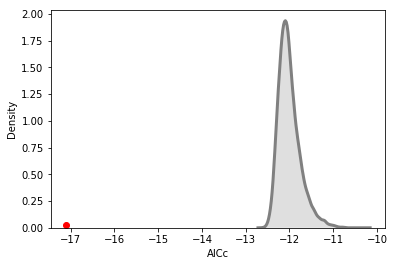

In [44]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.distplot(test['aic_c_new'], color = "grey", hist = False,
            kde_kws={"shade": True, "lw": 3})
ax.plot([aicc_new_1s], [0.025], marker = "o", color = "red")
plt.xlabel("AICc")
plt.ylabel("Density")
# sns.pointplot(x = aic_c_1S, color="red")
plt.savefig('DS9_twoState_AICc_KDE_corrected.pdf', dpi=300, bbox_inches='tight')
# 17/7810 had higher AIC

-38720.87088055412